All discussion here will be in relation to the code for the traditional autoencoder, seen in this [ADD LINK] post.

In [1]:
# imports
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(42); # set seed for consistent results

As in the traditional autoencoder, we must specify the dimensions of the code -- here, this will correspond to the dimension of both the mean $\mu$ and variance $\sigma^2$ vectors.

In [2]:
input_dimensions = 784
code_dimensions = 32

We're going to update our definitions for the encoder and decoder network classes. The encoder network must now yield both a mean and variance vector, while the structure of the decoder network can remain relatively unchanged. (We will actually have the encoder compute the log-variance rather than the variance directly as this lets us our network output negative values; once we exponentiate these to find the proper variance, we are guaranteed to end up with positive values as desired.)

In [3]:
class Encoder(nn.Module):
    """
    Encoder class for variational autoencoder. Takes in data of dimension `input_dimensions`, 
    conducts some transformation, and outputs the resulting code consisting of two vectors of dimension `code_dimensions`,
    the mean and log-variance vectors.  
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, (input_dimensions+code_dimensions)//2)
        self.fc2mean = nn.Linear((input_dimensions+code_dimensions)//2, code_dimensions)
        self.fc2logvar = nn.Linear((input_dimensions+code_dimensions)//2, code_dimensions)
        
    def forward(self, x: torch.Tensor):
        hidden1 = F.relu(self.fc1(x))
        code_mean = self.fc2mean(hidden1)
        code_logvar = self.fc2logvar(hidden1)
        return code_mean, code_logvar

In [4]:
class Decoder(nn.Module):
    """
    Decoder class for variational autoencoder. Takes in code sample of dimension `code_dimensions`, 
    conducts some transformation, and outputs the resulting output of dimension `input_dimensions`.
    """
    def __init__(self, code_dimensions: int, input_dimensions: int):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(code_dimensions, (input_dimensions+code_dimensions)//2)
        self.fc2 = nn.Linear((input_dimensions+code_dimensions)//2, input_dimensions)
    def forward(self, x: torch.Tensor):
        hidden1 = F.relu(self.fc1(x))
        output = torch.sigmoid(self.fc2(hidden1))
        return output

To construct the full VAE, we concatenate the encoder and decoder networks (as with the traditional autoencoder), but with the added step of conducting the reparametrization trick in between.

In [5]:
class VAE(nn.Module):
    """
    Class for variational autoencoder. Composite of Encoder and Decoder classes above, with the 
    reparametrization trick in between to allow for backpropagation through a stochastic process.
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(VAE, self).__init__()
        self.encode = Encoder(input_dimensions, code_dimensions)
        self.decode = Decoder(code_dimensions, input_dimensions)
        
    def reparametrize(self, mean: torch.Tensor, logvar: torch.Tensor):
        std_dev = torch.exp(0.5*logvar) # calculate the standard deviation for scaling
        epsilon = torch.randn_like(std_dev) # draw vector of dimension `code_dimensions` from standard normal
        return mean + epsilon*std_dev # return vector scaled by standard deviation and translated by mean
        
    def forward(self, x: torch.Tensor):
        code_mean, code_logvar = self.encode(x) # from input to parametrized distribution...
        sample = self.reparametrize(code_mean, code_logvar) # sample with reparametrization trick
        output = self.decode(sample)
        return output, code_mean, code_logvar

But we aren't done yet. We're still missing an integral part of the VAE framework: the new objective function. This is composed of the reconstruction error analogous to the original autoencoder loss (for which we'll use cross-entropy loss) and the KL-divergence term describing how far our code distributions are from unit Gaussians. Conveniently, the VAE paper gives us a closed form for this instance of it (more generally, we would use `torch.distributions`, but for this simple example we have no need).

In [6]:
def kl_divergence(mean: torch.Tensor, logvar: torch.Tensor):
    '''
    Takes as input two `code_dimension`-dimensional vectors representing the mean and log-variance 
    of a Gaussian distribution and outputs the (negative) KL-divergence of this with the unit Gaussian.
    '''
    return -0.5 * torch.sum(1 + logvar - torch.pow(mean, 2) - torch.exp(logvar))

In [7]:
def variational_lowerbound(input_data: torch.Tensor, output_data: torch.Tensor,
                           code_mean: torch.Tensor, code_logvar: torch.Tensor):
    '''
    Returns variational lower-bound (aka evidence lower-bound) for a VAE 
    given input data, a proposed reconstruction, and the code distributions.
    '''
#     print('output shape:', output_data.shape, 'input_shape:', input_data.shape)
    reconstruction_loss = F.binary_cross_entropy(output_data, input_data, reduction='sum')
    kl_loss = kl_divergence(code_mean, code_logvar)
    return reconstruction_loss + kl_loss

Now we're almost ready to train!

Going through some miscellaneous setup: 

In [8]:
# use gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
# some hyperparameters
batch_sz = 32
test_batch_sz = 100

learning_rate = 10**(-3)

n_epochs = 10

In [10]:
# set dataloader kwargs
kwargs = {'num_workers': 1, 'pin_memory':True} if torch.cuda.is_available() else {}

In [11]:
# preprocessing
img_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
# create dataloaders to serve up MNIST images as example data -- see MNIST example in the official documentation 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform= img_transform),
    batch_size=batch_sz,
    shuffle=True,
    **kwargs
)

In [13]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=img_transform),
    batch_size=test_batch_sz,
    shuffle=True,
    **kwargs
)

Setting up the model and initializing the Adam optimizer,

In [14]:
model = VAE(input_dimensions, code_dimensions).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, 
          train_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Executes one epoch of training given model, optimizer, device, dataloader, and epoch number.
    """
    model.train()
    for batch_idx, (inp, label) in enumerate(train_loader):
        inp = inp.view(-1, input_dimensions)
        inp = inp.to(device) 
        output, code_mean, code_logvar = model(inp) # here we put the input image through the VAE
        loss = variational_lowerbound(inp, output, code_mean, code_logvar)
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Died')
            break
        
        loss.backward() # compute gradients
        optimizer.step() # conduct step of gradient descent
        optimizer.zero_grad() # zero out gradients to avoid messing with future iterations
        
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inp), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(model: nn.Module, device: torch.device, test_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Computes error on test set given a model, device, dataloader, and epoch number.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inp, label) in enumerate(test_loader):
            inp = inp.view(-1, input_dimensions)
            inp = inp.to(device)
            output, code_mean, code_logvar = model(inp)
            test_loss += variational_lowerbound(inp, output, code_mean, code_logvar)
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [17]:
for epoch in range(1, n_epochs+1):
    train(model, optimizer, device, train_loader, epoch)
    test(model, device, test_loader, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 17584.925781
Train Epoch: 1 [32000/60000 (53%)]	Loss: 4101.734863

Test set: Average loss: 116.2248

Train Epoch: 2 [0/60000 (0%)]	Loss: 3681.470703
Train Epoch: 2 [32000/60000 (53%)]	Loss: 3519.761719

Test set: Average loss: 110.8681

Train Epoch: 3 [0/60000 (0%)]	Loss: 3543.985352
Train Epoch: 3 [32000/60000 (53%)]	Loss: 3235.022949

Test set: Average loss: 108.4604

Train Epoch: 4 [0/60000 (0%)]	Loss: 3841.058838
Train Epoch: 4 [32000/60000 (53%)]	Loss: 3662.301270

Test set: Average loss: 107.3888

Train Epoch: 5 [0/60000 (0%)]	Loss: 3051.623291
Train Epoch: 5 [32000/60000 (53%)]	Loss: 3232.370850

Test set: Average loss: 106.8985

Train Epoch: 6 [0/60000 (0%)]	Loss: 3346.608643
Train Epoch: 6 [32000/60000 (53%)]	Loss: 3394.134033

Test set: Average loss: 106.2145

Train Epoch: 7 [0/60000 (0%)]	Loss: 3452.067627
Train Epoch: 7 [32000/60000 (53%)]	Loss: 3244.714844

Test set: Average loss: 105.7724

Train Epoch: 8 [0/60000 (0%)]	Loss: 3192.741455

In [43]:
def generate_vae_samples(n: int):
    '''
    Function for generating n samples from the trained VAE. Currently, plots first of the n.
    '''
    noise_sample = torch.randn(n, code_dimensions).to(device)
    sample = model.decode(noise_sample)
    plt.imshow(sample.data.view(n,28,28).cpu().detach().numpy()[0], cmap='Greys_r')

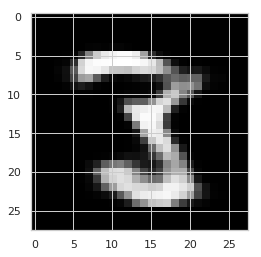

In [76]:
generate_vae_samples(1)